In [6]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [7]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper =api_wrapper_arxiv,description="Query Arxiv Papers")
print(arxiv.name)

arxiv


In [8]:
#test

arxiv.invoke("Agentic AI")

"Published: 2025-07-02\nTitle: AI Agents and Agentic AI-Navigating a Plethora of Concepts for Future Manufacturing\nAuthors: Yinwang Ren, Yangyang Liu, Tang Ji, Xun Xu\nSummary: AI agents are autonomous systems designed to perceive, reason, and act within\ndynamic environments. With the rapid advancements in generative AI (GenAI),\nlarge language models (LLMs) and multimodal large language models (MLLMs) have\nsignificantly improved AI agents' capabilities in semantic comprehension,\ncomplex reasoning, "

In [9]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper =api_wrapper_wiki,description="Query Arxiv Papers")
print(wiki.name)

wikipedia


In [14]:
#test
wiki.invoke("What is Computer Vision")

'Page: Computer vision\nSummary: Computer vision tasks include methods for acquiring, processing, analyzing, and understanding digital images, and extraction of high-dimensional data from the real world in order to produce numerical or symbolic information, e.g. in the form of decisions. "Understanding" in this context signifies the transformation of visual images (the input to the retina) into descriptions of the world that make sense to thought processes and can elicit appropriate action. This i'

In [15]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [16]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\meera\AppData\Local\Temp\ipykernel_28016\637379855.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [17]:
tavily.invoke("Provide me the latest YOLO model version")

[{'title': 'Ultralytics YOLO Docs: Home',
  'url': 'https://docs.ultralytics.com/',
  'content': "Introducing Ultralytics YOLO11, the latest version of the acclaimed real-time object detection and image segmentation model. YOLO11 is built on cutting-edge advancements in deep learning and computer vision, offering unparalleled performance in terms of speed and accuracy. Its streamlined design makes it suitable for various applications and easily adaptable to different hardware platforms, from edge devices to cloud APIs. [...] Ultralytics YOLO is the latest advancement in the acclaimed YOLO (You Only Look Once) series for real-time object detection and image segmentation. It builds on previous versions by introducing new features and improvements for enhanced performance, flexibility, and efficiency. YOLO supports various vision AI tasks such as detection, segmentation, pose estimation, tracking, and classification. Its state-of-the-art architecture ensures superior speed and accuracy, m

In [ ]:
#combining all these tools in the list
tools=[arxiv,wiki,tavily]

In [24]:
##initialize the LLM model
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")

In [25]:
llm.invoke("What is Agentic AI")

AIMessage(content='<think>\nOkay, so I need to figure out what Agentic AI is. Let me start by breaking down the term. "Agentic" might be related to "agent," and "AI" is artificial intelligence. So maybe Agentic AI is about AI that acts as an agent? But I\'m not sure. Let me think.\n\nFirst, I recall that in computer science, an agent is something that can act autonomously, make decisions, and interact with its environment. So an AI agent would be a program that can perform tasks on its own. But what makes Agentic AI special? Maybe it\'s more advanced than regular AI agents?\n\nI remember reading about AI agents in the context of chatbots or virtual assistants like Siri or Alexa. They can respond to queries, perform tasks, etc. But Agentic AI might be taking that a step further. Perhaps it\'s about AI that can handle more complex tasks, like planning, learning, adapting, and making decisions without constant human input.\n\nWait, I think there\'s a specific framework or concept called A

In [28]:
llm_with_tools=llm.bind_tools(tools=tools)

In [30]:
llm_with_tools.invoke("What is the latest yolo version? ")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the latest YOLO version. Let me think about how to approach this.\n\nFirst, YOLO, or You Only Look Once, is a popular object detection model. The versions have evolved over time, with contributions from different researchers and teams. The original YOLO was created by Joseph Redmon, and later versions like YOLOv2, YOLOv3, and YOLOv4 were developed. More recently, the BoT-SAM team has been involved in YOLO development, leading to YOLOv5 and YOLOv8. \n\nI remember that YOLOv8 is the latest version as of late 2023. But wait, I should verify this. The user might be looking for the most up-to-date information, so relying on my existing knowledge might not be sufficient. There could be a newer version released recently that I\'m not aware of. \n\nTo ensure accuracy, I should use the Tavily search engine to check the latest developments. The Tavily search function can provide current information about 

Workflow


In [36]:
##state Schema
from typing_extensions import TypedDict, List
from langchain_core.messages import AnyMessage # Human Message or AI message
from typing import Annotated #labelling
from langgraph.graph.message import add_messages #reducer in langgraph

In [42]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [43]:
## Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

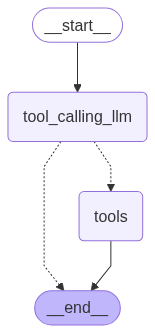

In [47]:
### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


#Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

##Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message (result) from the assistant is a tool call - tools_condition routes to tools
    # if the latest message (result) from the assistant is not a tool call - tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
#testing
messages=graph.invoke({"messages":"10.7759/cureus.76320"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

10.7759/cureus.76320
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (n3v47hyr7)
 Call ID: n3v47hyr7
  Args:
    query: 10.7759/cureus.76320
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "People's Attitude and Perception of the Pandemic on Twitter", "url": "https://www.cureus.com/articles/289414-peoples-attitude-and-perception-of-the-pandemic-on-twitter-a-case-study-of-covid-19-in-india", "content": "This study aims to identify and examine the emotions expressed and topics of discussion among Indian citizens related to COVID-19 third wave.", "score": 0.98554}, {"title": "People's Attitude and Perception of the Pandemic on Twitter - PubMed", "url": "https://pubmed.ncbi.nlm.nih.gov/39850180/", "content": "People's Attitude and Perception of the Pandemic on

In [51]:
#testing
messages=graph.invoke({"messages":"Hi, My name is Meera"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, My name is Meera
================================== Ai Message ==================================

Hello Meera! How can I assist you today? 😊
